<a href="https://colab.research.google.com/github/WhiteE45/OptimizacionConvexa/blob/main/ProyectoFinalOptimizacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyecto final

Las enfermedades cardiovasculares (ECV) son la principal causa de muerte en el mundo, siendo responsables de aproximadamente 17.9 millones de muertes al año, lo que representa el 31% de todas las muertes a nivel mundial.
Cuatro de cada cinco muertes por ECV se deben a ataques cardíacos y accidentes cerebrovasculares, y un tercio de estos fallecimientos ocurren prematuramente en personas menores de 70 años. La insuficiencia cardíaca es un evento común causado por las ECV, y existen otras caracteristicas que pueden utilizarse para predecir una enfermedad cardiaca.

Las personas con enfermedades cardiovasculares o con alto riesgo cardiovascular (debido a la presencia de uno o más factores de riesgo como hipertensión, diabetes, hiperlipidemia o enfermedad ya establecida) necesitan detección temprana y manejo adecuado.

El objetivo de este proyecto es desarrollar un modelo que pueda detectar un ECV en un paciente, deacuerdo con ciertas caracteristicas.

#Modelo a utilizar
El modelo elegido es regresion logistica, ya que se trata de una clasificacion binaria: el paciente tiene o no tiene un ECV.

Los hiperparametros que se utilizaran son:
- C = Inverso de la fuerza de regularización
- penalty = Tipo de regularización
- max_iter = Máximo número de iteraciones para converger


##Formulación Matemática del problema

Dado el modelo de regresión logística con hiperparámetros $$\theta = (C, \text{penalty}, \text{max_iter})$$, buscamos resolver:


$$\theta^* = \arg\max_{\theta \in \Theta} f(\theta)$$


donde:
- $f(\theta)$ es el F1-Score en validación cruzada.
- $\Theta$ es el espacio de búsqueda definido por:
  - $C \in [10^{-3}, 10^2]$ (escala logarítmica).
  - $\text{penalty} \in \{\text{L1} (Lasso), \text{L2} (Ridge)\}$.
  - $\text{max_iter} \in [100, 1000]$.

**Estrategia de Optimización Bayesiana**:
1. **Modelo de incertidumbre**: Se utiliza un proceso gaussiano (GP) para aproximar $f(\theta)$.
2. **Función de adquisición**: Se maximiza el Expected Improvement (EI) para seleccionar nuevos puntos.
3. **Actualización iterativa**: En cada paso, se evalúa $f(\theta)$ y se actualiza el GP.

## Desarrollo

In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 12.1 MB/s eta 0:00:00


In [24]:
import optuna
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [5]:
data = pd.read_csv('heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
# Variables cualitativas
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [7]:
# Variables cuantitativas
numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
scaler = StandardScaler()
data_encoded[numeric_cols] = scaler.fit_transform(data_encoded[numeric_cols])

In [8]:
data_encoded.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,0,1.382928,-0.832432,0,True,True,False,False,True,False,False,False,True
1,-0.478484,1.491752,-0.171961,0,0.754157,0.105664,1,False,False,True,False,True,False,False,True,False
2,-1.751359,-0.129513,0.770188,0,-1.525138,-0.832432,0,True,True,False,False,False,True,False,False,True
3,-0.584556,0.302825,0.139040,0,-1.132156,0.574711,1,False,False,False,False,True,False,True,True,False
4,0.051881,0.951331,-0.034755,0,-0.581981,-0.832432,0,True,False,True,False,True,False,False,False,True


In [9]:
X = data_encoded.drop('HeartDisease', axis=1)
y = data_encoded['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
# Optimizacion de hiperparametros
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 1e-3, 100, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': 'liblinear',
        'max_iter': trial.suggest_int('max_iter', 100, 1000)
    }
    model = LogisticRegression(**params)
    return cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-05-06 21:29:11,918] A new study created in memory with name: no-name-083a8916-57b7-4d7c-8f6e-7b9cf5d14676
[I 2025-05-06 21:29:11,976] Trial 0 finished with value: 0.8672716197098274 and parameters: {'C': 0.14367532306448474, 'penalty': 'l2', 'max_iter': 859}. Best is trial 0 with value: 0.8672716197098274.
[I 2025-05-06 21:29:12,030] Trial 1 finished with value: 0.8452800075898134 and parameters: {'C': 0.035533368040123824, 'penalty': 'l1', 'max_iter': 289}. Best is trial 0 with value: 0.8672716197098274.
[I 2025-05-06 21:29:12,083] Trial 2 finished with value: 0.8659512698301028 and parameters: {'C': 0.20363849491444655, 'penalty': 'l1', 'max_iter': 979}. Best is trial 0 with value: 0.8672716197098274.
[I 2025-05-06 21:29:12,135] Trial 3 finished with value: 0.8341485044230286 and parameters: {'C': 0.0015616064830015464, 'penalty': 'l2', 'max_iter': 660}. Best is trial 0 with value: 0.8672716197098274.
[I 2025-05-06 21:29:12,184] Trial 4 finished with value: 0.8687046547648162

In [26]:
optuna.visualization.plot_optimization_history(study)

## Evaluacion del modelo
Para poder evaluar el desempeño del modelo se utilizaron las siguientes metricas:
- f1-score: este es el valor que buscamos maximizar con nuestra funcion objetivo
- matriz de confusion
- curva ROC
- AUC

In [16]:
best_model = LogisticRegression(**study.best_params, solver='liblinear')
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Mejores parámetros:", study.best_params)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       112
           1       0.90      0.85      0.88       164

    accuracy                           0.86       276
   macro avg       0.85      0.86      0.85       276
weighted avg       0.86      0.86      0.86       276

Mejores parámetros: {'C': 0.27342078279175197, 'penalty': 'l1', 'max_iter': 433}


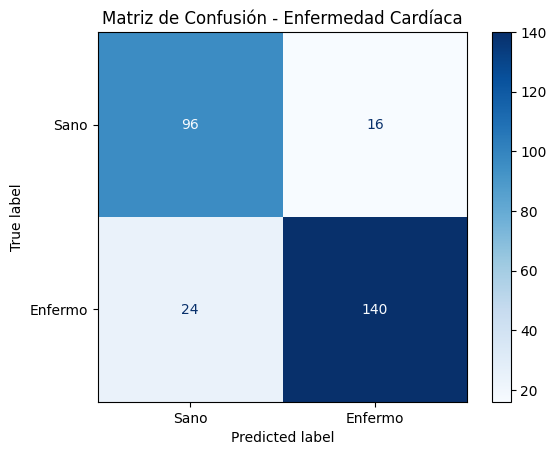

In [23]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])  # 0: Sano, 1: Enfermo

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sano", "Enfermo"])
disp.plot(cmap='Blues', values_format='d')  # 'd' para números enteros
plt.title('Matriz de Confusión - Enfermedad Cardíaca')
plt.show()

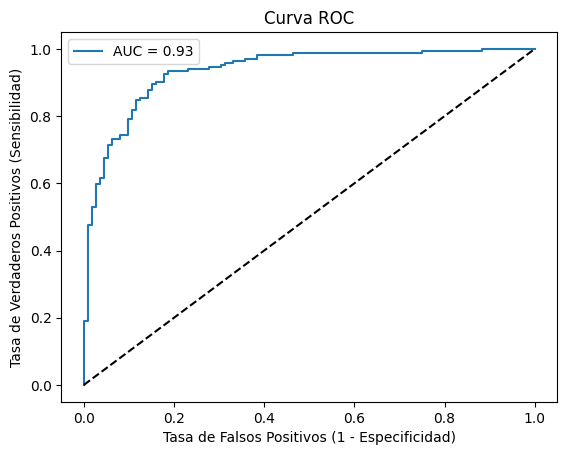

In [25]:
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilidades de clase 1
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC')
plt.legend()
plt.show()

## Conclusiones
Despues de haber optimizado nuestra funcion objetivo, el modelo con el mejor f1-score fue el 31, con los parametros 'C': 0.27342078279175197, 'penalty': 'l1', 'max_iter': 433 y un score de 0.87003.

Con esto, logramos obtener los resultados de nuestro modelo y evaluando con las metricas:
- f1-score 0.87 = nos indica que el modelo tiene un buen equilibrio entre precisión (enfermos correctamente identificados) y sensibilidad (no pasar por alto casos reales)
- matriz de confusion = clasifica correctamente un alto numero de casos (96 TN y 140 TP), sin embargo 24 pacientes fueron clasificados como sanos, lo cual es un riesgo cuando se trata de un diagnostico de este tipo
- curva de ROC y AUC = la curva se acerca a la esquina superior izquierda, lo que indica un numero bajo de falsos negativos. AUC por su parte, es de 0.93 lo que indica que el modelo distingue muy bien entre sanos y enfermos

Ademas podemos revisar los coeficientes de cada una de las features, para analisar cuales son los mayores indicadores de riesgo

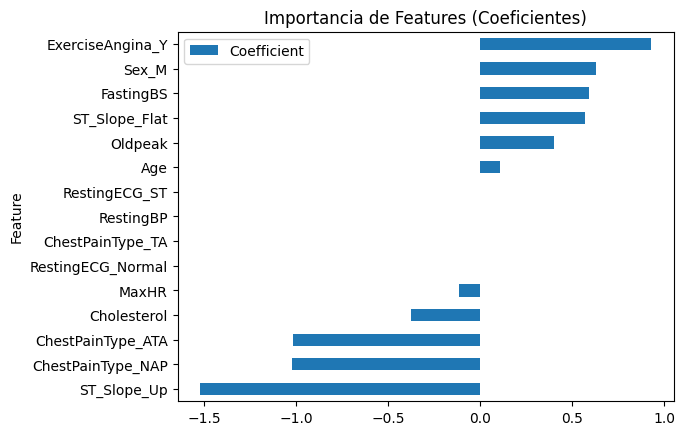

In [18]:
import matplotlib.pyplot as plt

coefs = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': best_model.coef_[0]})
coefs.sort_values('Coefficient').plot.barh(x='Feature', y='Coefficient')
plt.title('Importancia de Features (Coeficientes)')
plt.show()

In [20]:
best_model = LogisticRegression(**study.best_params, solver='liblinear')
best_model.fit(X_train, y_train)
print(pd.DataFrame({'Feature': X_train.columns, 'Coefficient': best_model.coef_[0]}))

              Feature  Coefficient
0                 Age     0.108559
1           RestingBP     0.000000
2         Cholesterol    -0.378052
3           FastingBS     0.590077
4               MaxHR    -0.114261
5             Oldpeak     0.403678
6               Sex_M     0.629665
7   ChestPainType_ATA    -1.016450
8   ChestPainType_NAP    -1.021437
9    ChestPainType_TA    -0.001049
10  RestingECG_Normal     0.000000
11      RestingECG_ST     0.000000
12   ExerciseAngina_Y     0.928298
13      ST_Slope_Flat     0.569907
14        ST_Slope_Up    -1.520041


Los coeficientes con impacto positivo son:
- ExerciseAngina_Y = 0.928
Pacientes con angina inducida por ejercicio (ExerciseAngina = Yes) tienen mayor riesgo.

- Sex_M = 0.630

- FastingBS = 0.590 (Ayuno glucémico)
Niveles altos de azúcar en ayunas están asociados a mayor riesgo.

- ST_Slope_Flat = 0.570
Pendiente plana en el electrocardiograma

features con impacto negativo:
- ST_Slope_Up = -1.520
Pendiente ascendente en el ECG está fuertemente asociada a corazones sanos.

- ChestPainType_NAP = -1.021 (Dolor no anginoso)
El dolor anginoso típico (TA) es más específico de enfermedad coronaria.

- Cholesterol = -0.378